# <span style="color:red">New York Stock Exchange price prediction</span>

The New York Stock Exchange (NYSE, nicknamed "The Big Board") is an American stock exchange at 11 Wall Street in the Financial District of Lower Manhattan in New York City. It is by far the world's largest stock exchange by market capitalization of its listed companies at 30.1 US dollars trillion as of February 2018. The average daily trading value was approximately 169 billion US dollars in 2013.

![ny_stock.jpg](ny_stock.jpg)

<b><FONT size="4pt">The aim of this project is to predict the share prices of companies listed on the New York Stock Exchange using Python and deep learning.</FONT></b>

It is extremely hard to predict the stock market.
Stock market prediction is the act of triying to determine the future value of a company stock.
Predicting such an unstable market in which many external factors come into play is very difficult.
But if you are able to successfully predict the price of a stock, you could gain an incredible amount of profit.

We are going to try to predict the price of Netflix.

## <span style="color:green">1. Choosing the data</span>

The first step was to choose the data.
We obtained the data from https://www.kaggle.com/dgawlik/nyse.

This is the most recent possible dataset showing price results up to 2017.

This dataset consists of following files:

- prices.csv: raw, as-is daily prices. Most of data spans from 2010 to the end 2016, for companies new on stock market date range is shorter. There have been approx. 140 stock splits in that time, this set doesn't account for that.
- prices-split-adjusted.csv: same as prices, but there have been added adjustments for splits.
- securities.csv: general description of each company with division on sectors
- fundamentals.csv: metrics extracted from annual SEC 10K fillings (2012-2016), should be enough to derive most of popular fundamental indicators.


## <span style="color:green">2. Choosing the model</span>

Using recurrent neural networks (RNN) in tensorflow.

## <span style="color:green">3. Building the model</span>

We import the different libraries.

In [91]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

We do some settings, as choosing the size of our train, validation and test sets.

In [92]:
# we split data in 80% for the train, 10% for validation and 10% for test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/Users/kevin/Documents/GitHub: ['Hate-speech-and-offensive-language-detection', '.DS_Store', 'New-York-Stock-Price-Prediction']
/Users/kevin/Documents/GitHub/New-York-Stock-Price-Prediction: ['NY Stock Price Prediction.ipynb', '.DS_Store', 'datasets', 'ny_stock.jpg', 'fedex-logo.png', '.ipynb_checkpoints', 'amazon-logo.png', '.git', 'netflix-logo.png']


We import the dataset.

In [93]:
# import all stock prices 
df = pd.read_csv("datasets/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])


<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['NRG', 'XYL', 'FB', 'CHK', 'RSG', 'XOM', 'NLSN', 'MOS', 'XEC', 'QCOM']


In [94]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [95]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


Creating functions.

In [97]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


## <span style="color:skyblue">Netflix prediction</span>

![netflix](netflix-logo.png)

We plot the actual stock values for Netflix, prices and volume.

In [98]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [99]:
dates = df.index.values

datelist = dates.tolist()

df['dates'] = datelist


df['dates']= pd.to_datetime(df['dates'])


df

,symbol,open,close,low,high,volume,dates
date,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2016-01-05
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,2016-01-06
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,2016-01-07
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,2016-01-08
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,2016-01-11
...,...,...,...,...,...,...,...
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,2016-12-30
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,2016-12-30
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,2016-12-30


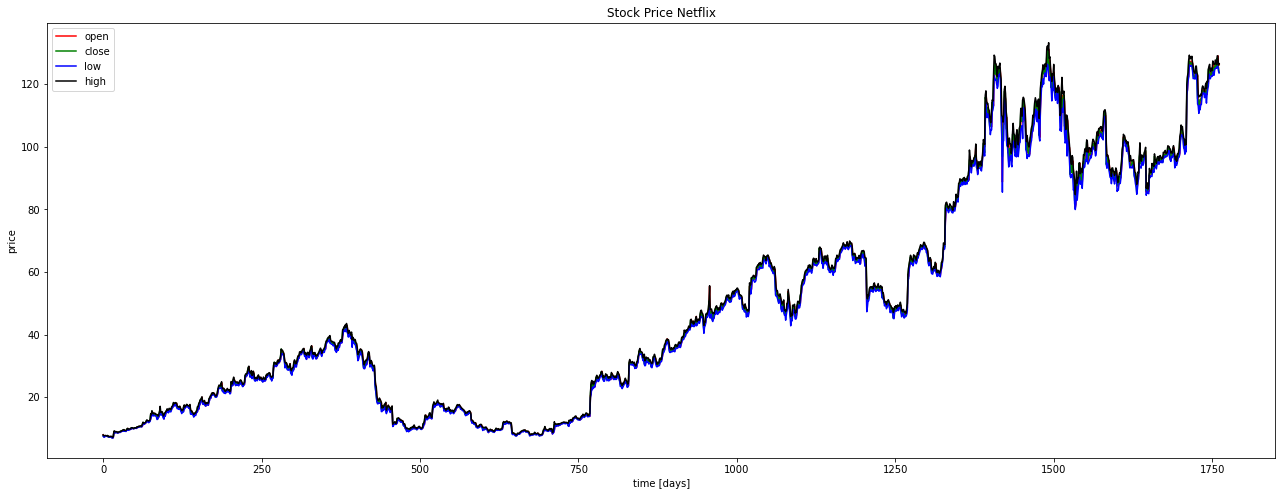

In [100]:
plt.figure(figsize=(22, 8))
plt.plot(df[df.symbol == 'NFLX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'NFLX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'NFLX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'NFLX'].high.values, color='black', label='high')

plt.title('Stock Price Netflix')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best');

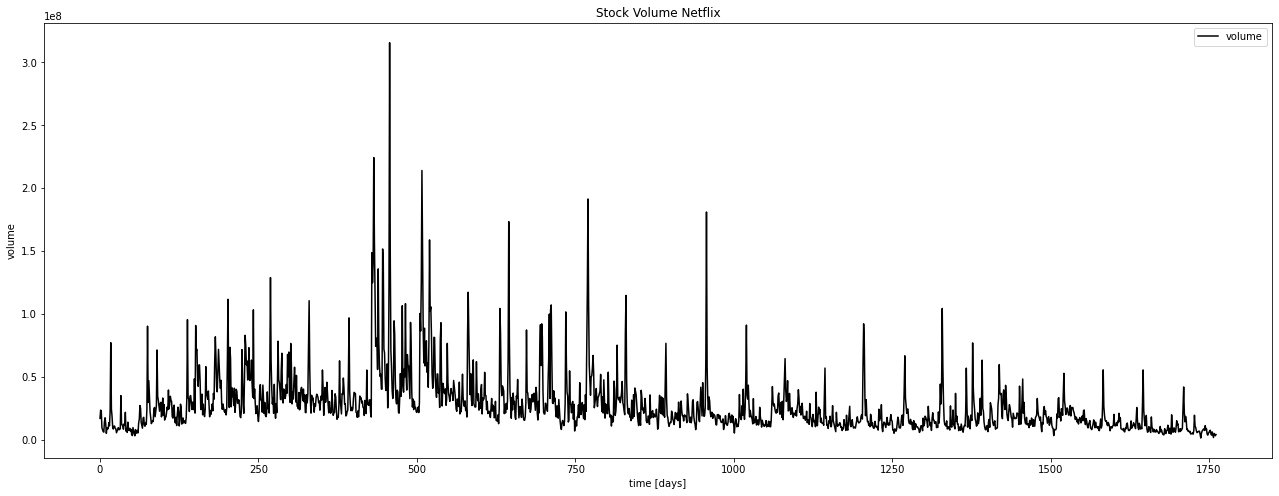

In [101]:
plt.figure(figsize=(22, 8))
plt.plot(df[df.symbol == 'NFLX'].volume.values, color='black', label='volume')
plt.title('Stock Volume Netflix')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

Here we choose the Netflix stock we are interested in and remove the unused values such as symbol and volume.

Then we normalize the data.
Normalizing time series data is benefitial when we want to compare multiple time series/stock price trends.
After normalization the price will be ranging in an interval between 0 and 1. So normalization is convenient for comparing price trends for multiple stocks in one graph.

It is also very important because Neural networks prefer standardized/normalized input so they can learn faster.

In [102]:
df_stock = df[df.symbol == 'NFLX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)
df_stock.drop(['dates'],1,inplace=True)

#NOTE JE NE PENSE PAS QUE CES 2 LIGNES SOIENT UTILE
cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

print(df_stock_norm)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
                open     close       low      high
date                                              
2010-01-04  0.007820  0.005015  0.005310  0.006209
2010-01-05  0.005577  0.002744  0.002739  0.003795
2010-01-06  0.003231  0.004831  0.002224  0.003920
2010-01-07  0.006210  0.003770  0.004449  0.004589
2010-01-08  0.004335  0.004808  0.004473  0.004475
...              ...       ...       ...       ...
2016-12-23  0.955083  0.956905  0.989034  0.944564
2016-12-27  0.960155  0.979179  0.994224  0.966532
2016-12-28  0.982935  0.959326  0.994726  0.966691
2016-12-29  0.957820  0.954806  0.981667  0.943454
2016-12-30  0.960155  0.942459  0.976645  0.946864

[1762 rows x 4 columns]


Let's define training and test sets for our model

In [103]:
# create train, validation and test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


We plot again the Netflix stock with the normalized prices

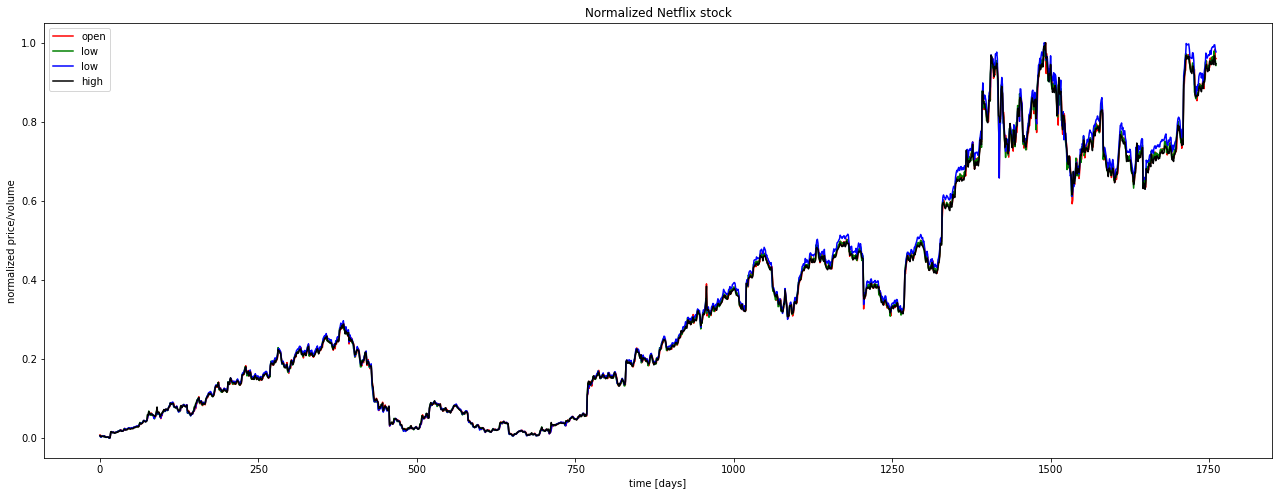

In [104]:
plt.figure(figsize=(22, 8));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')

plt.title('Normalized Netflix stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best');

We can now construct our model.
Let's start our Recurrent Neural Network


A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes form a direct graph along a sequence. This allows it to exhibit temporal dynamic behavior for a time sequence.

First we set the different parameters to define our RNN.
Variables need to be initialized, prior to model training.

In [117]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

We need two placeholders in order to fit our model. X contains the network's inputs and Y the network's outputs

In [118]:
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

We decide to have only to layers and set the input layer containing 200 neurons

We design the network architecture.
The hidden layers of the network are transformed by activation functions. Activation functions are important elements of the network architecture since they introduce non-linearity to the system.

Then we used the Adam optimizer wich is made for improving speed and performance for training a specific model.

At this point the model needs to be trained

In [ ]:
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(input_tensor=tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.469945/0.818941
4.99 epochs: MSE train/valid = 0.000241/0.001881
9.97 epochs: MSE train/valid = 0.000165/0.001315
14.96 epochs: MSE train/valid = 0.000152/0.001209
19.94 epochs: MSE train/valid = 0.000158/0.001194
24.93 epochs: MSE train/valid = 0.000115/0.000951
29.91 epochs: MSE train/valid = 0.000119/0.001085
34.90 epochs: MSE train/valid = 0.000211/0.001660
39.89 epochs: MSE train/valid = 0.000137/0.000972
44.87 epochs: MSE train/valid = 0.000149/0.001039
49.86 epochs: MSE train/valid = 0.000094/0.000790
54.84 epochs: MSE train/valid = 0.000103/0.000778
59.83 epochs: MSE train/valid = 0.000096/0.000760
64.81 epochs: MSE train/valid = 0.000090/0.000704
69.80 epochs: MSE train/valid = 0.000099/0.000681


In [114]:
y_train.shape

(1394, 4)

Now we want to plot the predictions et zoom it to see what will happen in the future.

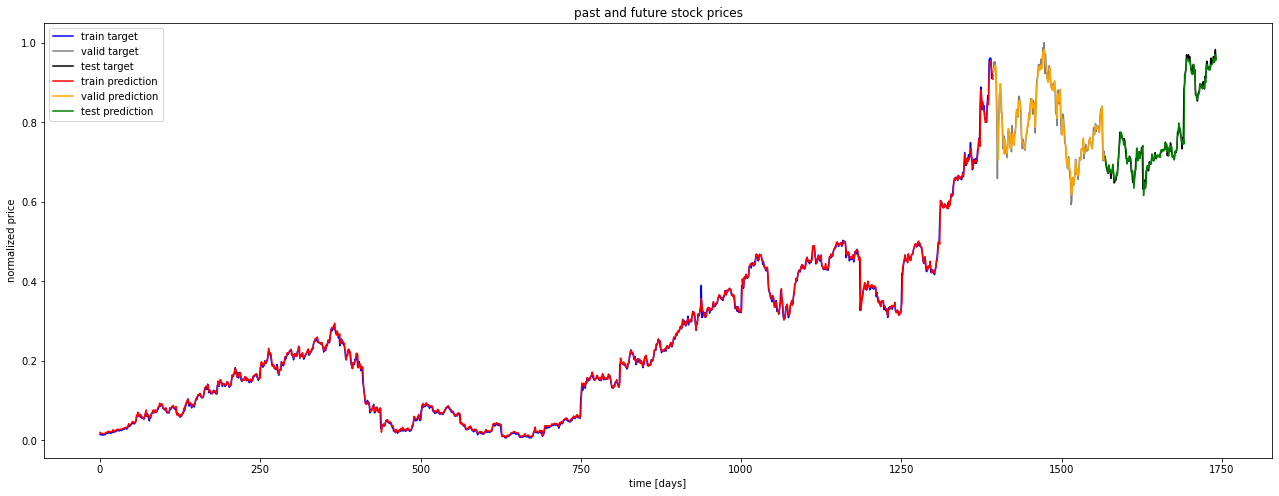

In [115]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(22, 8));

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

correct sign prediction for close - open price for train/valid/test: 0.52/0.46/0.46


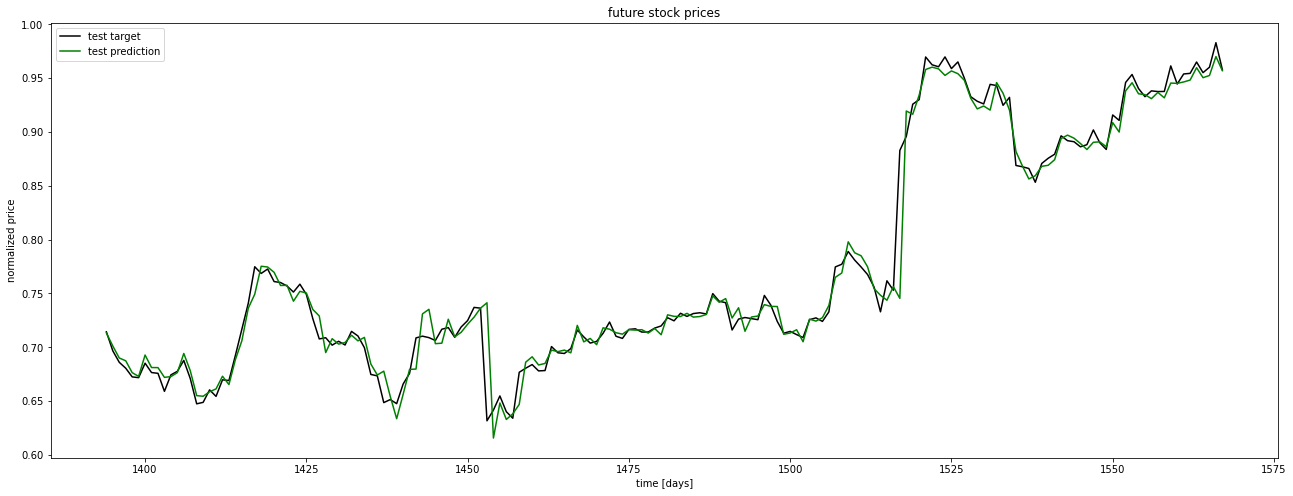

In [116]:
plt.figure(figsize=(22, 8));
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

In [80]:
CONCLUSION

NameError: name 'CONCLUSION' is not defined